In [2]:
# Lectura del conjunto de datos utilizando Pandas
import pandas as pd

df = pd.read_csv('lista_prestamos.csv')
df

,Fecha,Destino,Edad,Ingresos,Zona geografica,Perfil,Plazo,Cuota,class
0,22/03/2024,Refaccion y construccion de vivienda,45,2000000,Buenos Aires,A,6,1,Al dia
1,18/03/2024,Decoracion,40,5000000,La Pampa,AA,6,1,Al dia
2,21/02/2024,Refaccion y construccion de vivienda,52,935000,Rio Negro,AA,18,1,Al dia
3,19/02/2024,Viaje,70,450000,Corrientes,AA,18,1,Al dia
4,06/02/2024,Refaccion y construccion de vivienda,57,326000,Buenos Aires,C,6,1,Al dia
...,...,...,...,...,...,...,...,...,...
401,10/01/2018,Decoracion,45,21600,Buenos Aires,F,48,48,+180 dias
402,09/01/2018,Otros destinos,36,14000,Santa Fe,D,48,48,+180 dias
403,04/01/2018,Refaccion y construccion de vivienda,50,30000,Buenos Aires,E,48,48,+180 dias
404,04/01/2018,Refaccion y construccion de vivienda,35,32355,Ciudad de Buenos Aires,D,48,48,+180 dias


In [57]:
import pandas as pd
from datetime import datetime
dolar = pd.read_csv('dolarMEP.csv')
dolar

,dolar,Fecha
0,16.96,01/01/17
1,17.98,01/12/17
2,20.26,01/03/18
3,20.80,01/04/18
4,21.08,01/05/18
...,...,...
1548,1036.25,21/03/24
1549,1036.16,22/03/24
1550,1012.94,25/03/24
1551,1027.09,26/03/24


In [48]:
# Realizamos una copia del original para no trabajar sobre esta

df_orig= df.copy()
df.head()

,Fecha,Destino,Edad,Ingresos,Zona geografica,Perfil,Plazo,Cuota,class
0,22/03/2024,Refaccion y construccion de vivienda,45,2000000,Buenos Aires,A,6,1,Al dia
1,18/03/2024,Decoracion,40,5000000,La Pampa,AA,6,1,Al dia
2,21/02/2024,Refaccion y construccion de vivienda,52,935000,Rio Negro,AA,18,1,Al dia
3,19/02/2024,Viaje,70,450000,Corrientes,AA,18,1,Al dia
4,06/02/2024,Refaccion y construccion de vivienda,57,326000,Buenos Aires,C,6,1,Al dia


In [10]:
# vemos que tipo de datos tiene el data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Fecha            406 non-null    object
 1   Destino          406 non-null    object
 2   Edad             406 non-null    int64 
 3   Ingresos         406 non-null    int64 
 4   Zona geografica  406 non-null    object
 5   Perfil           406 non-null    object
 6   Plazo            406 non-null    int64 
 7   Cuota            406 non-null    int64 
 8   class            406 non-null    object
dtypes: int64(4), object(5)
memory usage: 28.7+ KB


Fecha              object
Destino            object
Edad                int64
Ingresos            int64
Zona geografica    object
Perfil             object
Plazo               int64
Cuota               int64
class              object
dtype: object

In [73]:
from datetime import datetime

df_prueba1= df.copy()
dolar_prueba = dolar.copy()
#formatear fechas a datetime

df_prueba1['Fecha']= pd.to_datetime(df_prueba1['Fecha'])
dolar_prueba['Fecha']=pd.to_datetime(dolar_prueba['Fecha'])
df_prueba1['dolar']=""
df_prueba1

for x in range(0,(10),1):
    cond=False
    dia=pd.to_timedelta('1 days')
    dia_inicial=pd.to_timedelta('0 days')

    while cond==False:
        print("+")
        print(dia)
        for y in range(0,(len(dolar_prueba.index)+1),1):
            print('+++++++++++++++++++)

    
            if (df_prueba1['Fecha'][x]+ dia)==dolar_prueba['Fecha'][y]:
                print('++++++++')
                df_prueba1[dolar][x]=dolar_prueba[dolar][y]
                print(df_prueba1[dolar][x])
                cond=True
                break
            dia=dia_inicial + dia
df_prueba1
            







C:\Users\UDLEA\AppData\Local\Temp\ipykernel_1236\434785725.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_prueba1['Fecha']= pd.to_datetime(df_prueba1['Fecha'])
C:\Users\UDLEA\AppData\Local\Temp\ipykernel_1236\434785725.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dolar_prueba['Fecha']=pd.to_datetime(dolar_prueba['Fecha'])


+
1 days 00:00:00
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
+++++++++++++++++++
++

KeyError: 1553

In [112]:
from datetime import datetime
df_prueba1= df.copy()
df_prueba1['Fecha']= pd.to_datetime(df_prueba1['Fecha'])


dia

C:\Users\UDLEA\AppData\Local\Temp\ipykernel_1468\2681524941.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_prueba1['Fecha']= pd.to_datetime(df_prueba1['Fecha'])


TypeError: unsupported operand type(s) for +: 'Timedelta' and 'int'

In [113]:
# Al analizar la base de datos, tendremos que hacer varias modificaciones para representarlo correctamente 
# para ingresos lo pasaremos a dolares utilizando una base de dato donde tenemos según meses el valor máximo de valor mep
# con respecto a la cuota lo dividiremos por el plazo para tener un porcentaje de avance de los pagos 
# con respecto a clases dividiremos en los que son "Al dia" -> "bueno" y todos los demas como "malo"
# cuando ingresemos una nueva entrada lo pasaremos por esta función 
#transformaremos a travez de Sklearn ->LabelEncoder de valores categoricos a numéricos (Destino-Zona Geografica-Perfil-class)


df_prueba= df.copy()


def editor_fichero(fichero):

    def convertir_etiqueta(fichero): #empezamos por class
        fichero.loc[fichero['class'] == 'Al dia', 'class'] = 'Bueno'
        fichero.loc[fichero['class'] != 'Bueno', 'class'] = 'malo'
        return fichero
    

    def convertir_cuota_en_porcentaje(fichero): #modificamos las cuotas por un porcentaje de avance del cuota/plazo
        fichero['porcentaje_Avance'] = fichero['Cuota']/fichero['Plazo']
        del fichero['Cuota']
        return fichero
    
    def pasar_ingresos_a_dolares(fichero):  #pasar a dolares los ingresos - sacamos el mayor dolar de cada mes y ese será el valor a convertir
        
        





        return fichero
    
    return pasar_ingresos_a_dolares(convertir_cuota_en_porcentaje(convertir_etiqueta(fichero)))


editor_fichero(df_prueba)




,Fecha,Destino,Edad,Ingresos,Zona geografica,Perfil,Plazo,class,porcentaje_Avance
0,22/03/2024,Refaccion y construccion de vivienda,45,2000000,Buenos Aires,A,6,Bueno,0.166667
1,18/03/2024,Decoracion,40,5000000,La Pampa,AA,6,Bueno,0.166667
2,21/02/2024,Refaccion y construccion de vivienda,52,935000,Rio Negro,AA,18,Bueno,0.055556
3,19/02/2024,Viaje,70,450000,Corrientes,AA,18,Bueno,0.055556
4,06/02/2024,Refaccion y construccion de vivienda,57,326000,Buenos Aires,C,6,Bueno,0.166667
...,...,...,...,...,...,...,...,...,...
401,10/01/2018,Decoracion,45,21600,Buenos Aires,F,48,malo,1.000000
402,09/01/2018,Otros destinos,36,14000,Santa Fe,D,48,malo,1.000000
403,04/01/2018,Refaccion y construccion de vivienda,50,30000,Buenos Aires,E,48,malo,1.000000
404,04/01/2018,Refaccion y construccion de vivienda,35,32355,Ciudad de Buenos Aires,D,48,malo,1.000000


In [85]:
# Mostrar los valores únicos que tiene un atributo determinado
df["Edad"].value_counts()


Edad
45    23
40    20
38    20
42    18
39    17
54    16
49    16
46    16
43    16
51    14
37    13
48    13
41    13
53    13
47    13
44    13
34    12
50    12
36    11
52    11
57    11
32     9
35     8
56     8
33     6
59     5
28     5
60     5
63     5
30     5
64     5
55     4
58     4
29     4
68     3
31     3
65     3
26     2
61     2
70     2
62     2
69     1
22     1
66     1
20     1
67     1
Name: count, dtype: int64

In [58]:
#mostrar los valores de prestamos al día 
df["class"].value_counts()

class
+180 dias    237
Al dia       154
+120 dias      6
+60 dias       4
+30 dias       3
+90 dias       2
Name: count, dtype: int64

<Axes: >

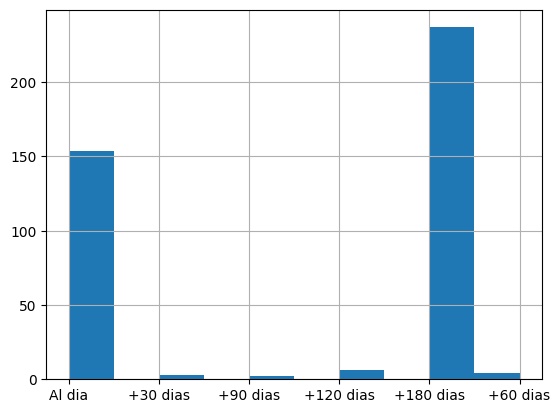

In [59]:
# Mostrar los valores de la característica como un histograma
%matplotlib inline
import matplotlib.pyplot as plt
df["class"].hist()

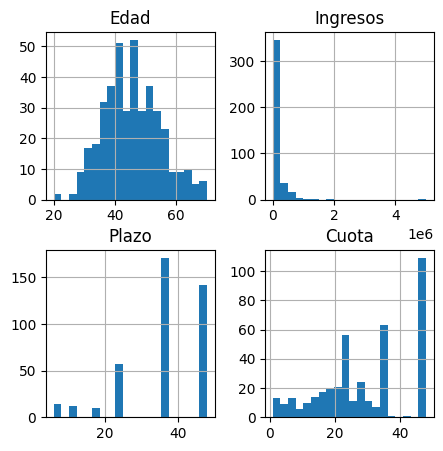

In [65]:
# Representar gráficamente la distribución de los atributos
df.hist(bins=20, figsize=(5,5))
plt.show()

In [ ]:
# 